This code represents an attempt to replicate the DeepClean 1D convolutional neural network to reduce the signal-to-noise ratio in gravitational waves.

In [1]:
#Given pseudocode to grab the .h5 data file
import numpy as np
import h5py
from scipy import signal
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

with h5py.File("data/deepclean-1251335314-4097.h5", "r") as f:
    X = []
    for channel, timeseries in f.items():
        if channel == "H1:GDS-CALIB_STRAIN":
            y = timeseries[:]
        else:
            X.append(timeseries[:])
X = np.stack(X, axis=-1) # this will do channels last (as is typically done for Keras)
print(X.shape)
print(y.shape)



/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-03-01 21:15:19.095496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 21:15:19.284019: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-01 21:15:20.342505: W tensorflow/compiler/xla/stream_executor/platform/default/dso_load

(16781312, 21)
(16781312,)


(32, 32768, 21)
(32, 32768)


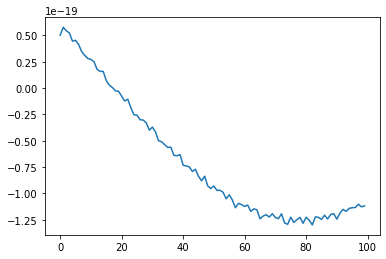

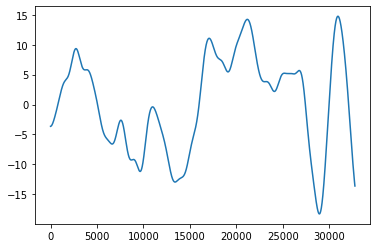

In [2]:

# then to construct inputs/outputs, you just
# slice windows from these two timeseries
window_length = 8
sample_rate = 4096
window_size = window_length * sample_rate

# sample a batch of random windows
batch_size = 32
X_batch, y_batch = [], []
for i in range(batch_size):
    idx = np.random.randint(X.shape[0] - window_size)
    X_batch.append(X[idx: idx + window_size])
    y_batch.append(y[idx: idx + window_size])

X_batch = np.stack(X_batch)
y_batch = np.stack(y_batch)

print(X_batch.shape)
print(y_batch.shape)

plt.plot(y[0:100])
plt.show()
plt.plot(X_batch[0][:, 0])
plt.show()



strain_data = y_batch
witness_data = X_batch
channels = 21

Building Butterworth Filter


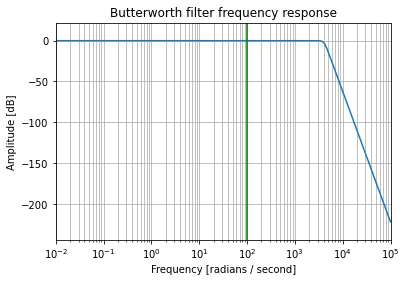

Butterworth filter built


In [3]:
#Preprocessing:
#Normalize the data
"""
Pre-processing data structure:

1. Anti-Imaging filter: Resample witness channels, Y, to the same frequency as the strain;
    - Currently, witness and strain are all sampled at 4096 Hz
2. 8th Order Butterworth: Aliasing filter to mitigate power from outside the witnessed noise frequencies;

3. StandardScalar: Unit variance, Zero mean;

4. Windowing: Divide data into smaller overlapping windows;
    - Segment Length: 8.00 Seconds;
    - 0.5 Hz => DFT of 2 Seconds;
    
5. Welches Method: 1 Second DFT overlap;

6. Training: Segment overlap [%] = 96.875

7. Testing: Segment overlap [%] = 50%
"""

# 2.0: Butterworth
print("Building Butterworth Filter")
N = 8 # order of butterworth filter
Wn = [0, 4096] #passband [low end, high end]
filter_type = "bp"
fs = Wn[1]/2

b, a = signal.butter(N, Wn, filter_type, analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()
butter_sos = signal.butter(N, Wn, filter_type, fs , output = 'sos')
print("Butterworth filter built")


Applying Butterworth to data
(32, 32768, 21)


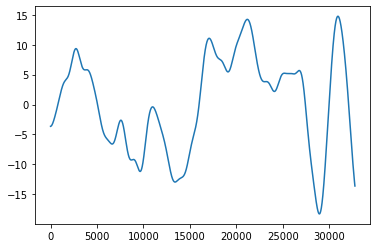

/tmp/ipykernel_3764/2548299418.py:8: RuntimeWarning: overflow encountered in cast
  witness_data[idx][:, channel] = signal.sosfilt(butter_sos, witness_data[idx][:, channel])


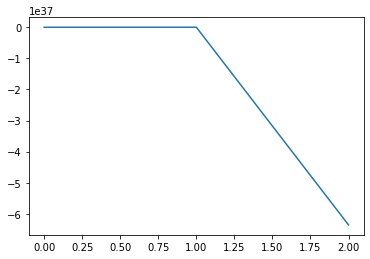

Butterworth filter applied to data


In [4]:
# 2.1: Apply butter_sos to data
print("Applying Butterworth to data")
print(witness_data.shape)
plt.plot(witness_data[0][:,0])
plt.show()
for idx in range(len(witness_data)):
    for channel in range(channels):
        witness_data[idx][:, channel] = signal.sosfilt(butter_sos, witness_data[idx][:, channel])
plt.plot(witness_data[0][:,0])
plt.show()
print("Butterworth filter applied to data")

Normalization in progress


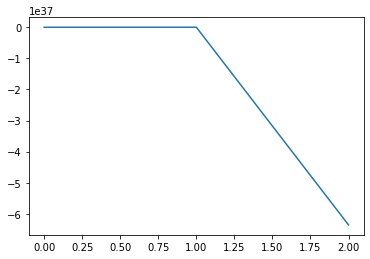

/home/mvigil/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input X contains infinity or a value too large for dtype('float32').

In [5]:

# 3: Standard Scalar (Z-score)
print("Normalization in progress")

plt.plot(witness_data[0][:,0])
plt.show()

scaler = StandardScaler()
strain_data = np.reshape(strain_data, (-1,1))
scaler.fit(strain_data)
strain_data = scaler.transform(strain_data)


test_1 = scaler.transform(np.reshape(witness_data[1][:,0], (-1,1)))



plt.plot(test_1, label = "Z_score")
plt.plot(witness_data[0][:,0], label = "OG Data")
plt.legend()
plt.show()
# print(witness_data.shape)

# for idx in range(len(witness_data)):
#     for channel in range(channels):
#         reshaped_witness_data = np.reshape(witness_data[idx][:, channel], (-1,1))
#         reshaped_witness_data = scaler.transform(reshaped_witness_data)
# print(witness_data.shape)


print("Normalization Complete")

In [6]:
# 4: Windowing
window_length = 8
DFT_length = 2
sample_rate = 4096
window_size = window_length * sample_rate
DFT_size = DFT_length * sample_rate
overlap_percent = 0.96875



In [7]:
# 5: Welches Method
print("Applying Welch's Method")
window_type = 'hann'
nperseg_train = window_size
noverlap_train = window_size*(1-overlap_percent)
nfft = DFT_size

for batch in range(len(witness_data)):
    for channel in range(channels):
        witness_data[idx][:, channel] = signal.welch(witness_data[idx][:, channel], sample_rate, window = 'hann')
        
print("Welch's Method Complete")

Applying Welch's Method


/home/mvigil/.local/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

In [ ]:
print(X_batch.shape)
print(X_batch.shape[0])
print(X_batch.shape[1])
print(X_batch.shape[2])

In [9]:
#Implement neural network.

#TOY MODEL COPY-PASTED FROM HW3
#MODEL FOR PART B, MODIFIED TO REPLICATE
#FIGURE 7 IN THE SOURCE WORK
from tensorflow.keras import layers

#Check input shape, given dataset is sampled at 4096Hz
model = keras.models.Sequential(name="attempt_1")
#Convolution Layers
model.add(layers.Conv1D(filters=21, kernel_size=5, strides=1, padding="same", activation="tanh",\
                        input_shape=(X_batch.shape[1], X_batch.shape[2])))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=8, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=16, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=32, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=64, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())

#Deconvolution Layers
model.add(layers.Conv1DTranspose(filters=32, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(filters=16, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(filters=8, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(filters=21, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=1, kernel_size=5, padding="same", name = "output"))

model.build((None, X_batch.shape[1], X_batch.shape[0]))
model.summary()

Model: "attempt_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 32768, 21)         2226      
                                                                 
 batch_normalization (BatchN  (None, 32768, 21)        84        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 16384, 8)          848       
                                                                 
 batch_normalization_1 (Batc  (None, 16384, 8)         32        
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 8192, 16)          656       
                                                                 
 batch_normalization_2 (Batc  (None, 8192, 16)         64

In [10]:
#Toy code, need to double check lr_schedule parameters with literature

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=100, decay_rate=0.8)


model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=["accuracy"])

results = model.fit(
    X_batch,
    y_batch,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1, min_lr=1e-5),
        keras.callbacks.EarlyStopping(patience=15, verbose=1),
    ],
)

Epoch 1/10


2023-03-01 21:16:42.001519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-01 21:16:42.632010: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-03-01 21:16:43.467611: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55e7c15958e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-01 21:16:43.467692: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GeForce RTX 2080 Ti, Compute Capability 7.5
2023-03-01 21:16:43.483863: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECT

1/1 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0000e+00

2023-03-01 21:16:47.464866: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


1/1 [==============================] - 10s 10s/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - 0s 138ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00 - lr: 9.9777e-04
Epoch 3/10
1/1 [==============================] - 0s 137ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00 - lr: 9.9555e-04
Epoch 4/10
1/1 [==============================] - 0s 138ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00 - lr: 9.9333e-04
Epoch 5/10
1/1 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0000e+00
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0004955569747835398.
1/1 [==============================] - 0s 165ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00 - lr: 9.9111e-04
Epoch 6/10
1/1 [==============================] - 0s 162ms/step